In [ ]:
!pip install botorch
!pip install brian2
!pip install /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation/lib/TuRBO

# Import

In [ ]:
# --- Jupyter setup ---
%load_ext autoreload
%autoreload 2

# --- System path setup ---
import os
import sys
sys.path.append(os.getcwd())
print("Current directory:", os.getcwd())

# --- Import basic python packages ---
import math
import time
import warnings
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as color_map_package


# --- Brian2 ---
from brian2 import *


# --- for cma, turbo, and baseline_bo ---
import cma
from turbo import TurboM
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_gaussian_process, plot_convergence


# --- PyTorch & GPyTorch ---
import torch
from torch import nn
from torch.quasirandom import SobolEngine
import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


# --- BoTorch ---
from botorch import manual_seed
from botorch.acquisition import LogExpectedImprovement, qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.gp_regression import SingleTaskGP as STGP
from botorch.models.kernels import InfiniteWidthBNNKernel
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.optim.optimize import optimize_acqf as optimize_acqf_fn
from botorch.test_functions import Ackley
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize

# --- Custom Utilities ---
from utils.sim_utils import set_params_utils, eqs_utils, plotting_utils, obj_func_utils, set_param_space
from utils.methods_utils import ibnn_utils, shared_utils, cma_utils
from utils.training_utils import eval_utils, plot_eval_utils

# --- Warning filters ---
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation


INFO       Cache size for target 'cython': 5256 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/Users/dusiyi/Library/Caches/cython/brian_extensions' directory. [brian2]
WARNING    /opt/miniconda3/envs/brian2_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]


# Set up simulation environment

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation
Starting simulation at t=0. s for a duration of 8.1 s
2.3289 s (28%) simulated in 10s, estimated 25s remaining.
4.6737 s (57%) simulated in 20s, estimated 15s remaining.
7.0545 s (87%) simulated in 30s, estimated 4s remaining.
8.1 s (100%) simulated in 35s


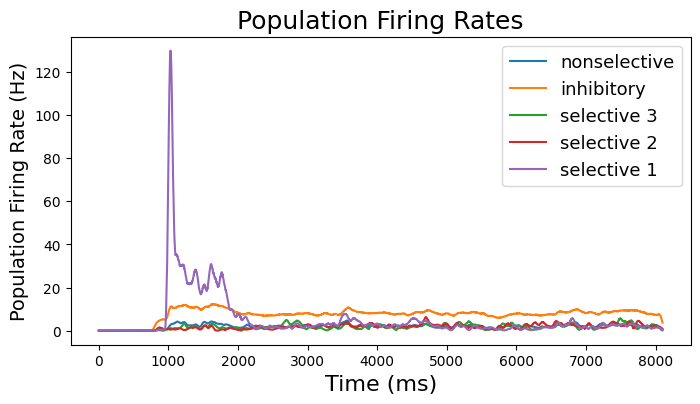

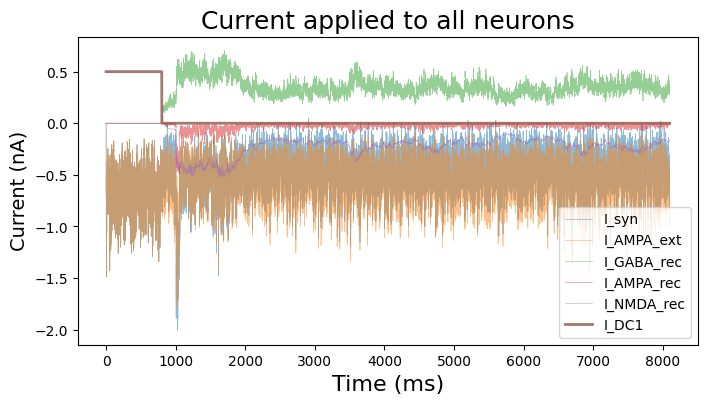

In [2]:
from utils.training_utils.set_train_env import*

# Train models

## Turbo

https://github.com/uber-research/TuRBO/blob/master/README.md

In [ ]:
n_trust_regions = 2 

for num_run in range(3):  
    result_dir = f'all_stored_results/all_turboM/TR{n_trust_regions}_run{num_run+1}'

    turbo_m = TurboM(
        f=objective_with_factor,  # Handle to objective function
        lb=stim_bounds_norm.numpy()[0,:],  # Numpy array specifying lower bounds
        ub=stim_bounds_norm.numpy()[1,:],  # Numpy array specifying upper bounds
        n_init=5,  # Number of initial bounds from an Symmetric Latin hypercube design
        max_evals=200,  # Maximum number of evaluations
        n_trust_regions=n_trust_regions,  # Number of trust regions
        batch_size=5,  # How large batch size TuRBO uses
        verbose=True,  # Print information from each batch
        use_ard=True,  # Set to true if you want to use ARD for the GP kernel
        max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
        n_training_steps=50,  # Number of steps of ADAM to learn the hypers
        min_cuda=1024,  # Run on the CPU for small datasets
        device="cpu",  # "cpu" or "cuda"
        dtype="float64",  # float64 or float32
    )

    turbo_m.optimize()

    updated_x = torch.tensor(turbo_m.X)
    updated_y = torch.tensor(turbo_m.fX)
    updated_y = - updated_y
    os.makedirs(result_dir, exist_ok=True)
    torch.save(updated_x, os.path.join(result_dir, "updated_x.pt"))
    torch.save(updated_y, os.path.join(result_dir, "updated_y.pt"))


## IBNN

https://botorch.org/docs/tutorials/ibnn_bo/

In [ ]:
optimize_hypers = False
N_ITERATIONS = 200
network_depth = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acqf_class_to_use = LogExpectedImprovement

for num_run in range(3):  
    result_dir = f'all_stored_results/all_ibnn/depth{network_depth}_run{num_run+1}'

    # --- get initial data ---
    init_points_folder = os.path.join(result_dir, "init_points")
    init_x, init_y = shared_utils.retrieve_or_sample_init_points(init_points_folder, objective_func_tensor, stim_bounds_norm)

    # --- define kernels ---
    ibnn_kernel = InfiniteWidthBNNKernel(network_depth, device=device)
    ibnn_kernel.weight_var = 10.0
    ibnn_kernel.bias_var = 5.0
    ibnn_kernel = ScaleKernel(ibnn_kernel, device=device)

    # --- run BO loop ---
    run_bo_with_acqf = partial(ibnn_utils.gp_bo_loop, f=objective_func_tensor, bounds=stim_bounds_norm, acqf_class=acqf_class_to_use, 
                            result_dir=result_dir,
                            init_x=init_x, 
                            init_y=init_y, 
                            n_iterations=N_ITERATIONS,
                            )
    ibnn_x, ibnn_y = run_bo_with_acqf(kernel=ibnn_kernel, optimize_hypers=False)

## CMA

In [ ]:
popsize = 4
x0 = [0.1, 0.7, 0.3, 0.7]
sigma = 0.3

for num_run in range(3):  
    result_dir = f'all_stored_results/all_cma/pop{popsize}_run{num_run+1}'

    means = []
    sigmas = []
    all_params = []
    all_values = []
    best_params_over_time = []
    best_values_over_time = []

    es = cma.CMAEvolutionStrategy(x0, sigma, {'popsize': popsize, 
                                            'maxiter': math.ceil(200/popsize),
                                            'bounds': [[0] * len(x0), [1] * len(x0)],
                                            })
    
    iteration = 0
    while not es.stop():
        iteration += 1
        solutions = es.ask()
        fitnesses = [objective_with_factor(x) for x in solutions]
        es.tell(solutions, fitnesses)
        print(f"Iteration {iteration} | Best so far: {es.best.f}")

        # Track values
        means.append(es.mean.copy())
        sigmas.append(es.sigma)
        all_params.extend(solutions)
        all_values.extend(fitnesses)
        best_params_over_time.append(min(fitnesses))
        best_values_over_time.append(solutions[np.argmin(fitnesses)])
        
        # Save the parameters and values
        updated_x = torch.tensor(all_params)
        updated_y = torch.tensor(all_values)
        updated_y = - updated_y
        os.makedirs(result_dir, exist_ok=True)
        torch.save(updated_x, os.path.join(result_dir, "updated_x.pt"))
        torch.save(updated_y, os.path.join(result_dir, "updated_y.pt"))


## baseline BO

In [ ]:
N_ITERATIONS = 200

def print_iteration(res):
        print(f"Iteration {len(res.x_iters)} | Best so far: {res.fun:.4f}")

def save_bo_results(res, result_dir='all_stored_results/bo_results'):
    train_x = torch.tensor(res['x_iters'])
    y_vals = res['func_vals'].reshape(-1, 1)
    y_vals = - y_vals  # because the BO function minimizes the objective function
    train_y = torch.tensor(y_vals)
    shared_utils.save_results(train_x, train_y, result_dir=result_dir)
    return train_x, train_y

for num_run in range(3):  
    result_dir = f'all_stored_results/all_bo/bo_run{num_run+1}'

    init_points_folder = os.path.join(result_dir, "init_points")
    init_x, init_y = shared_utils.retrieve_or_sample_init_points(init_points_folder, objective_func_tensor, stim_bounds_norm)
    init_y = -init_y
    
    res = gp_minimize(objective_with_factor, # the function to minimize
                    space_norm,
                    x0=init_x.tolist(),
                    y0=init_y.reshape(-1).numpy().tolist(),
                    acq_func="EI",      # the acquisition function
                    n_calls=N_ITERATIONS,         # the number of evaluations of f
                    n_random_starts=5,  # the number of random initialization points
                    noise='gaussian',       # the noise level (optional)
                    callback=[print_iteration],
                    #random_state=1234
                    )   # the random seed

    train_x, train_y = save_bo_results(res, result_dir=result_dir)

# Plot count above threshold

For each run of each method, get the of iterations that have values above 5000 ms. We'll choose the run with the highest count as the top run for that method.

## get results

In [37]:
all_results_dir_dict = shared_utils.get_all_results_dir_dict()

unnorm_factor = 7000
threshold = 5000
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict, verbose=False)

count_df = eval_utils.count_high_values(y_dict, threshold=threshold/unnorm_factor)
top_method_instances_df = count_df.sort_values(by=['method', 'count'], ascending=False).groupby('method').first()
top_method_instances = {}
for method, row in top_method_instances_df.iterrows():
    top_method_instances[method] = row['name']


print('Names of top instance of each method:')
print(top_method_instances)
print(count_df.sort_values(by=['method', 'count'], ascending=False))

Names of top instance of each method:
{'bo': 'bo_run3', 'cma': 'pop4_run2', 'ibnn': 'depth4_run3', 'turbo': 'TR2_run2'}
           name  count  percentage  total_points method hyperparam
1      TR2_run2     39          20           200  turbo        TR2
4      TR2_run1     19          10           200  turbo        TR2
10     TR2_run3      1           0           200  turbo        TR2
6   depth4_run3     11           6           200   ibnn     depth4
8   depth4_run2      8           4           200   ibnn     depth4
9   depth4_run1      8           4           200   ibnn     depth4
0     pop4_run2     52          30           172    cma       pop4
2     pop4_run3     38          19           200    cma       pop4
3     pop4_run1     22          11           200    cma       pop4
5       bo_run3     17           8           200     bo         bo
7       bo_run2      8           4           200     bo         bo


## plot all runs

top_method_instances: dict_values(['bo_run3', 'pop4_run2', 'depth4_run3', 'TR2_run2'])


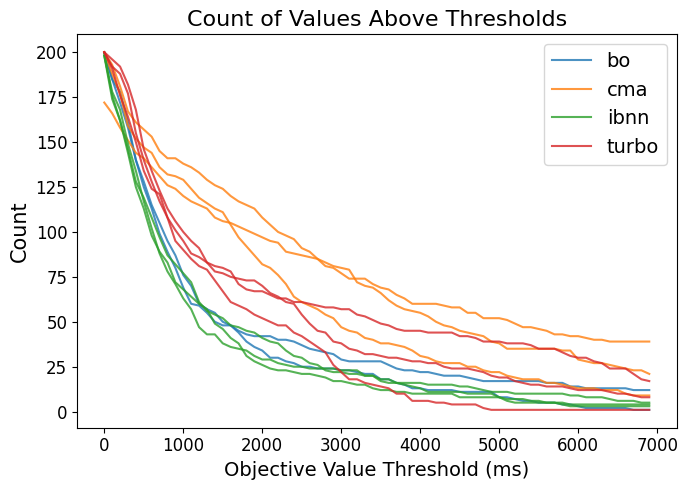

In [38]:
print('top_method_instances:', top_method_instances.values())
comb_df = eval_utils.get_count_of_high_values_over_threshold(y_dict, one_instance_per_method=False)

# unique_labels = comb_df['method'].sort_values().unique()
unique_labels = ['bo', 'cma', 'ibnn', 'turbo'] # hard-coded here to fix the color sequence
colors = color_map_package.get_cmap('tab10')
color_map  = {label: colors(i) for i, label in enumerate(unique_labels)}

# we want it so that only once run of each method is labeled and thus appear in the legend
label_column='name'
# initially, we set all labels to None
label_map = {key: None for key in comb_df['name'].unique()}
# then we set the label for one instance (in this case, the best-performing instance, but it doensn't matter) of each method
label_map.update({value: key for key, value in top_method_instances.items()})


plot_eval_utils.plot_count_over_value_thresholds(comb_df.copy(), groupby_column='name', 
                                                 color_column='method', color_map=color_map,
                                                 label_column=label_column, label_map=label_map)


## plot top run of each method

top_method_instances: dict_values(['bo_run3', 'pop4_run2', 'depth4_run3', 'TR2_run2'])


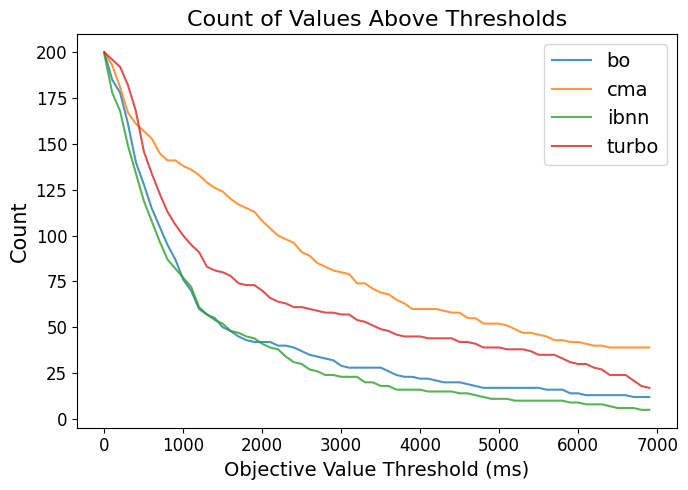

In [39]:
unnorm_factor = 7000
threshold = 5000
all_results_dir_dict = shared_utils.get_all_results_dir_dict()
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict, verbose=False)

#y_dict_sub = {k: y_dict[k] for k in top_method_instances.values()}
print('top_method_instances:', top_method_instances.values())
comb_df = eval_utils.get_count_of_high_values_over_threshold(y_dict)
plot_eval_utils.plot_count_over_value_thresholds(comb_df)

## by methods

Method: bo


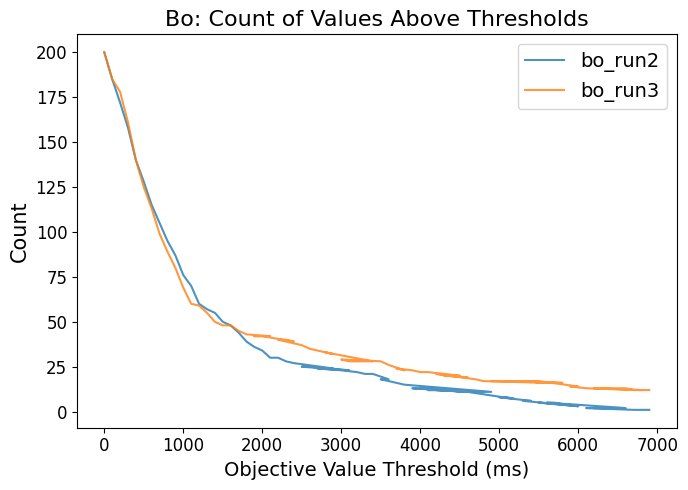

Method: cma


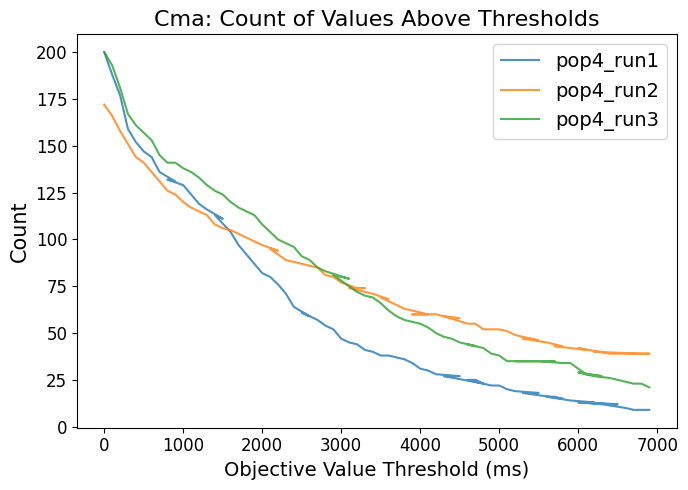

Method: ibnn


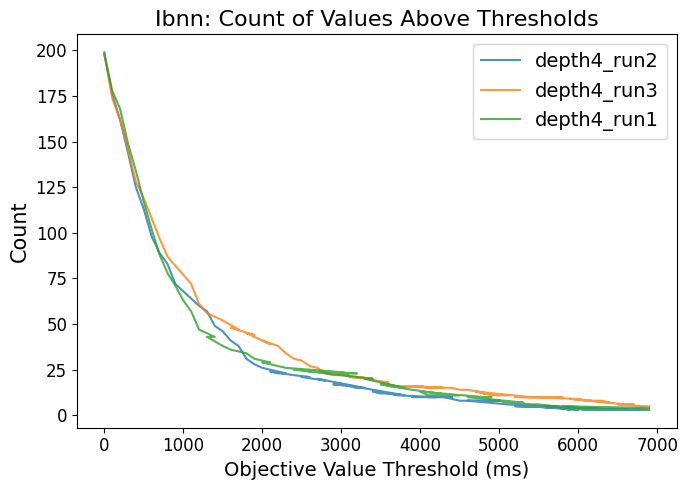

Method: turbo


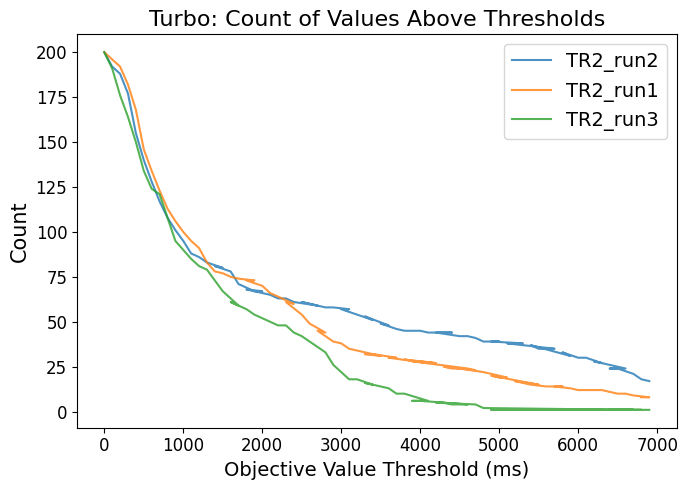

In [40]:
# if combine all instances across methods
all_results_dir_dict = shared_utils.get_all_results_dir_dict()
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict, verbose=False)

comb_df = eval_utils.get_count_of_high_values_over_threshold(y_dict, one_instance_per_method=False)
for method in comb_df.method.unique():
    print(f"Method: {method}")
    sub_df = comb_df[comb_df.method == method].sort_values(by='percentage', ascending=False)
    plot_eval_utils.plot_count_over_value_thresholds(sub_df, groupby_column='name', prefix=f'{method.capitalize()}: ')

# Plot value over iter

## plot all runs

Loaded pop4_run1
Loaded pop4_run2
Loaded pop4_run3
Failed to load results for method 'bo_run1': [Errno 2] No such file or directory: 'all_stored_results/all_turboM/bo_run1/run_0/updated_x.pt'
Loaded bo_run2
Loaded bo_run3
Loaded depth4_run2
Loaded depth4_run3
Loaded depth4_run1
Loaded TR2_run2
Loaded TR2_run3
Loaded TR2_run1


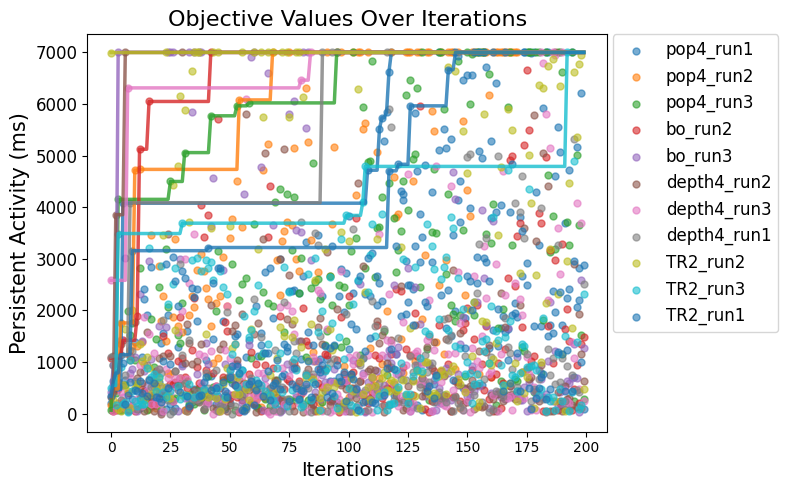

In [41]:
num_top_points = 20
all_results_dir_dict = shared_utils.get_all_results_dir_dict()
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict)
plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict)

## plot top run of each method

Loaded bo
Loaded cma
Loaded ibnn
Loaded turbo


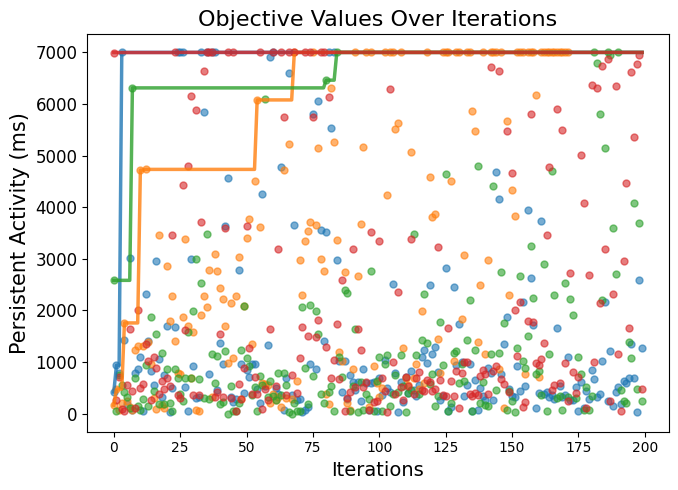

In [42]:
top_method_dirs = {}
for method, name in top_method_instances.items():
    top_method_dirs[method] = all_results_dir_dict[name]
x_dict, y_dict = shared_utils.load_top_optimization_results(top_method_dirs)
ax = plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict, show_plot=False)
# removed the legend here because in the report, it shares the same color scheme as the one next to it
plt.legend().remove()
plt.show()

## by methods

### CMA

Found dict_keys(['pop4_run1', 'pop4_run2', 'pop4_run3'])
Loaded pop4_run1
Loaded pop4_run2
Loaded pop4_run3


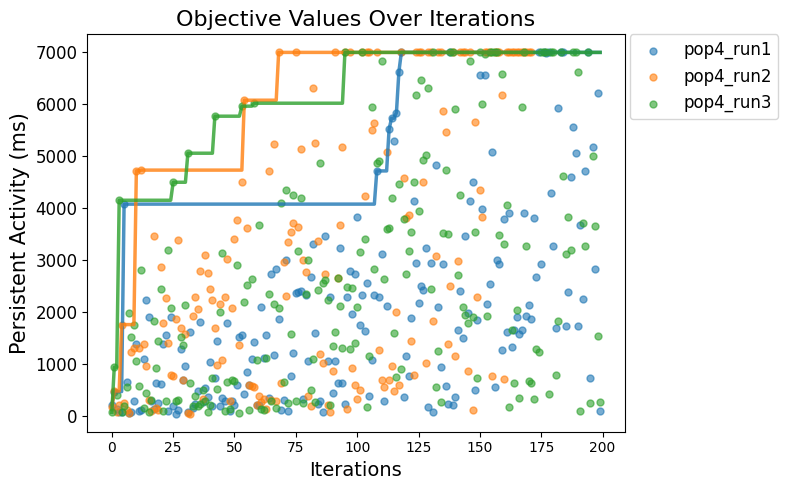

In [43]:
group_size = 3

results_dir_dict = shared_utils.get_all_dir_from_method('cma')

methods = list(results_dir_dict.keys())
for group in range(math.ceil(len(methods) / group_size)):
    temp_result_dict = {}
    for method in methods[group * group_size:(group + 1) * group_size]:
        temp_result_dict[method] = results_dir_dict[method]
    x_dict, y_dict = shared_utils.load_top_optimization_results(temp_result_dict, prefix='run_')
    plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict)

### BO

Found dict_keys(['bo_run1', 'bo_run2', 'bo_run3'])
Loaded bo_run1
Loaded bo_run2
Loaded bo_run3


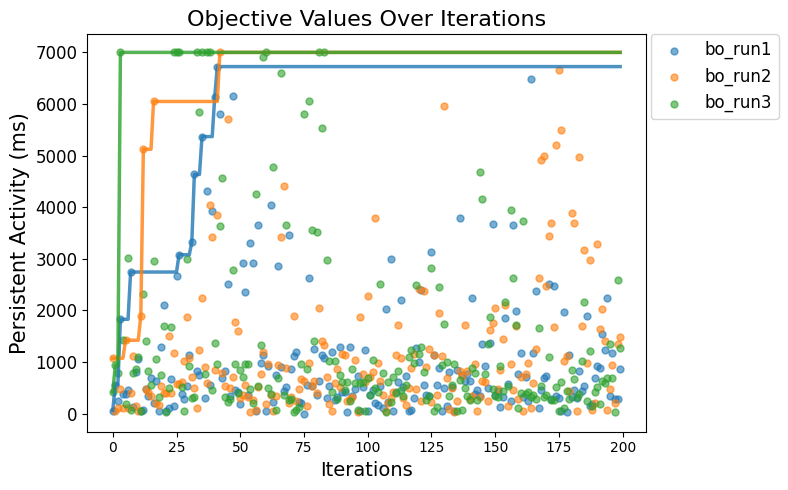

In [44]:
group_size = 4

results_dir_dict = shared_utils.get_all_dir_from_method('bo')

methods = list(results_dir_dict.keys())
for group in range(math.ceil(len(methods) / group_size)):
    temp_result_dict = {}
    for method in methods[group * group_size:(group + 1) * group_size]:
        temp_result_dict[method] = results_dir_dict[method]
    x_dict, y_dict = shared_utils.load_top_optimization_results(temp_result_dict, prefix='run_')
    plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict)

### ibnn

Found dict_keys(['depth4_run2', 'depth4_run3', 'depth4_run1'])
Loaded depth4_run2
Loaded depth4_run3
Loaded depth4_run1


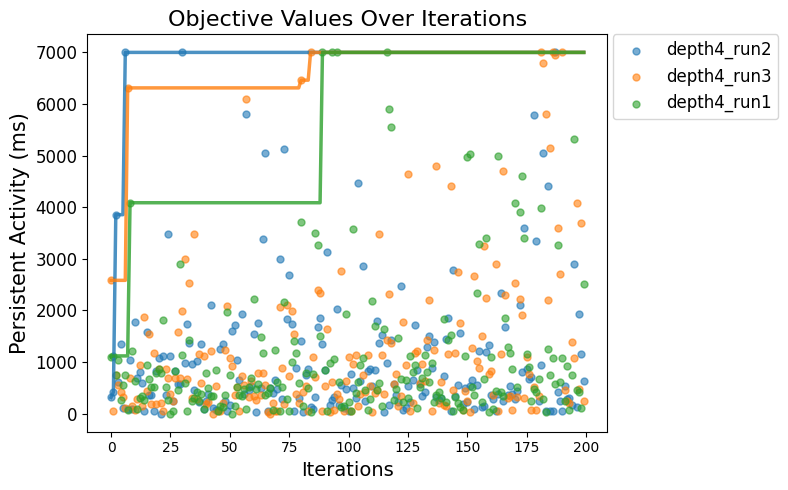

In [45]:
group_size = 3

results_dir_dict = shared_utils.get_all_dir_from_method('ibnn')

methods = list(results_dir_dict.keys())
for group in range(math.ceil(len(methods) / group_size)):
    temp_result_dict = {}
    for method in methods[group * group_size:(group + 1) * group_size]:
        temp_result_dict[method] = results_dir_dict[method]
    x_dict, y_dict = shared_utils.load_top_optimization_results(temp_result_dict, prefix='run_')
    plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict)

### turboM

Found dict_keys(['bo_run1', 'TR2_run2', 'TR2_run3', 'TR2_run1'])
Failed to load results for method 'bo_run1': [Errno 2] No such file or directory: 'all_stored_results/all_turboM/bo_run1/run_0/updated_x.pt'
Loaded TR2_run2
Loaded TR2_run3


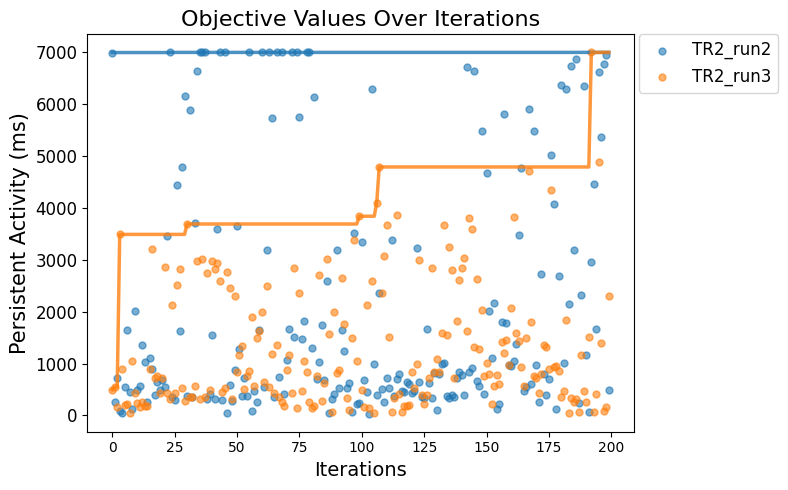

Loaded TR2_run1


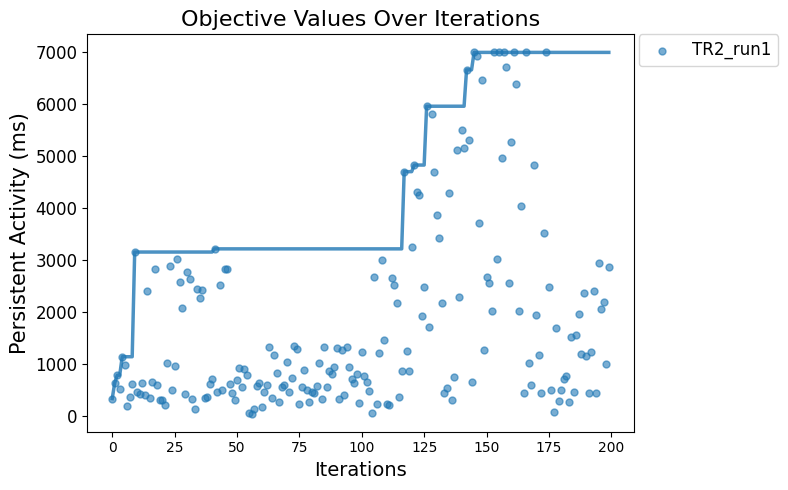

In [46]:
group_size = 3

results_dir_dict = shared_utils.get_all_dir_from_method('turboM')

methods = list(results_dir_dict.keys())
for group in range(math.ceil(len(methods) / group_size)):
    temp_result_dict = {}
    for method in methods[group * group_size:(group + 1) * group_size]:
        temp_result_dict[method] = results_dir_dict[method]
    x_dict, y_dict = shared_utils.load_top_optimization_results(temp_result_dict, prefix='run_')
    plot_eval_utils.plot_both_value_and_cum_max_over_iter(x_dict, y_dict)

# Cross Validate on top params

## run repeats on top params

In [ ]:
x_rep_dict = {}
y_rep_dict = {}

top_method_dirs = {}
for key, value in top_method_instances.items():
    top_method_dirs[key] = all_results_dir_dict[value]

verbose = True
prefix = 'run_'
num_repeats = 10
num_top_points = 10

shared_utils.check_all_results_exist(top_method_dirs)
print('Starting to iterate over methods...')

for method in top_method_dirs.keys():
    iter_df_path = f'all_stored_results/compare_methods/iter_df_{method}.csv'
    avg_eval_df_path = f'all_stored_results/compare_methods/avg_eval_df_{method}.csv'
    result_dir = top_method_dirs[method]
    try:
        if verbose:
            print(f"Method: {method}")
        updated_x, updated_y = shared_utils.get_latest_results(result_dir)

        all_best_params, all_values_reps, iter_eval_df = eval_utils.repeat_eval_top_params(
            updated_x, updated_y, objective_func_tensor_w_plot, method, num_top_points=num_top_points, num_repeats=num_repeats,
            iter_df_path=iter_df_path)

        x_rep_dict[method] = all_best_params
        y_rep_dict[method] = all_values_reps

        avg_eval_df, all_averages = eval_utils.build_avg_eval_df(y_rep_dict)
        avg_eval_df.to_csv(avg_eval_df_path, index=False)
        print(f'After adding {method}, avg_eval_df shape: {avg_eval_df.shape}. It\'s saved to {avg_eval_df_path}')

    except Exception as e:
        if verbose:
            print(f"Failed to load results for method '{method}': {e}")


## plot avg values

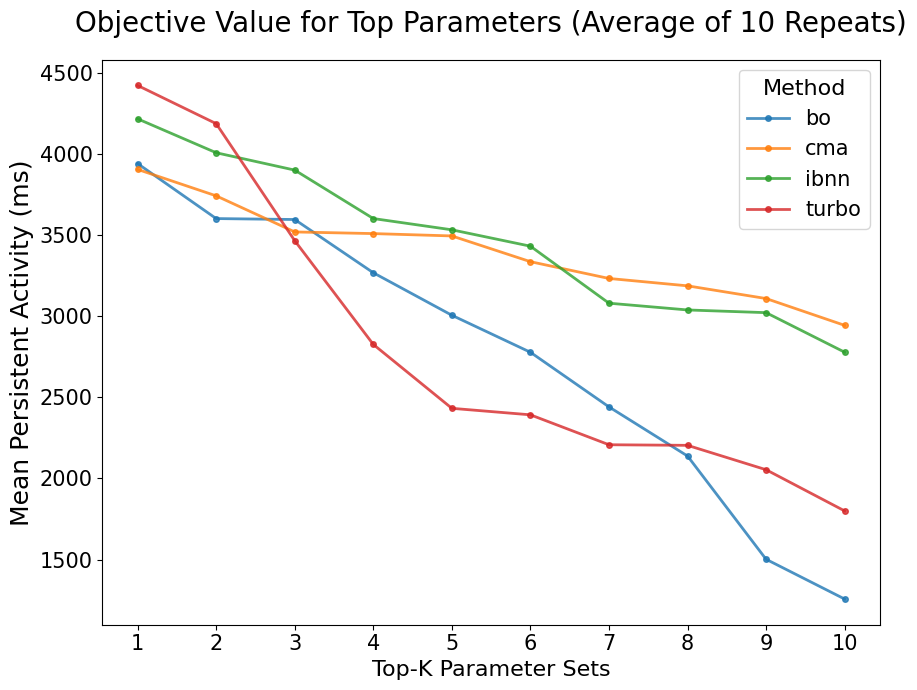

In [51]:
iter_df_dir = '/Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation/all_stored_results/compare_methods'
avg_eval_comb = pd.read_csv(os.path.join(iter_df_dir, 'avg_eval_comb.csv'))

avg_eval_df_sorted = avg_eval_comb
all_methods = []
# for each column in all methods, sort the column in descending order
for method in avg_eval_comb.columns:
    if method == 'Top-K':
        continue
    all_methods.append(method)
    avg_eval_df_sorted[method] = avg_eval_df_sorted[method].sort_values(ascending=False).reset_index(drop=True)
# sort all_methods
all_methods.sort() # in order to match the color in other plots
plot_eval_utils.plot_avg_eval_df(avg_eval_df_sorted, all_methods=all_methods)

## to pick param set for sample result

### get best result iteration index

In [52]:
# for each method, get the param index with the best result in the cross-validation
method = [col for col in avg_eval_comb.columns if 'Top-K' not in col]
top_param_index_dict = {}
for method in avg_eval_comb.columns[1:]:
    sub = avg_eval_comb.sort_values(by=method, ascending=False)[['Top-K', method]]
    top_param_index_dict[method] = sub.iloc[0]['Top-K'].astype(int)
    #print(f"Method: {method}")
    #print(f"Top parameter index for {method}: {sub['Top-K']}")
top_param_index_dict

{'ibnn': 1, 'cma': 1, 'turbo': 1, 'bo': 1}

### retrieve or merge iter_df_comb

In [ ]:
try:
    iter_df_comb = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_comb.csv'))
except FileNotFoundError:
    print(f"File not found: {os.path.join(iter_df_dir, 'iter_df_comb.csv')}. Creating a new one through merging.")
    iter_df_ibnn = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_ibnn.csv'))
    iter_df_cma = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_cma.csv'))
    iter_df_turbo = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_turbo.csv'))
    iter_df_bo = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_baseline_bo.csv'))

    # merge iter_df
    iter_df_comb = pd.concat([iter_df_ibnn, iter_df_cma, iter_df_turbo, iter_df_bo], ignore_index=True).reset_index(drop=True)
    #iter_df_comb.to_csv(os.path.join(iter_df_dir, 'iter_df_comb.csv'), index=False)



### get k & inter of best result for each method
This can be used to manually find plots that show the best performance of each method, from the output of the section 'Run repeats on top params'

In [74]:
for method, k_index in top_param_index_dict.items():
    sub = iter_df_comb[iter_df_comb['method'] == method]
    sub = sub[sub['top_k'] == k_index].sort_values(by='y_value', ascending=False).iloc[[0]].reset_index(drop=True)
    print(sub[['method', 'top_k', 'num_iter', 'y_value']])


  method  top_k  num_iter  y_value
0   ibnn      1        10  0.75487
  method  top_k  num_iter  y_value
0    cma      1         2  0.99591
  method  top_k  num_iter  y_value
0  turbo      1         7  0.76729
  method  top_k  num_iter  y_value
0     bo      1         6  0.82099


# Plot top param range

To see the distribution of top parameters for each method

## all params

In [75]:
space = set_param_space.space
stim_bounds = set_param_space.stim_bounds

In [76]:
method_mapping = {
    'turbo': 0,
    'ibnn': 1,
    'cma': 2,
    'bo': 3
}

y_tick_label_mapping = {value: key for key, value in method_mapping.items()}

method_to_y_pos_mapping = {}
for key in all_results_dir_dict.keys():
    method, _ = eval_utils.get_method(key)
    # each method only needs to be labeled once
    method_to_y_pos_mapping[key] = method_mapping[method]


index_to_params = {i: dim.name for i, dim in enumerate(space)}
print('index_to_params:', index_to_params)
param_name_list = ['Start time (ms)', 'Duration (ms)', 'Amplitude (nA)', 'Slope of amplitude (nA/ms)']
print('param_list:', param_name_list)

index_to_params: {0: 'DC_start_time1', 1: 'DC_duration1', 2: 'DC_amp1', 3: 'DC_amp_slope1'}
param_list: ['Start time (ms)', 'Duration (ms)', 'Amplitude (nA)', 'Slope of amplitude (nA/ms)']


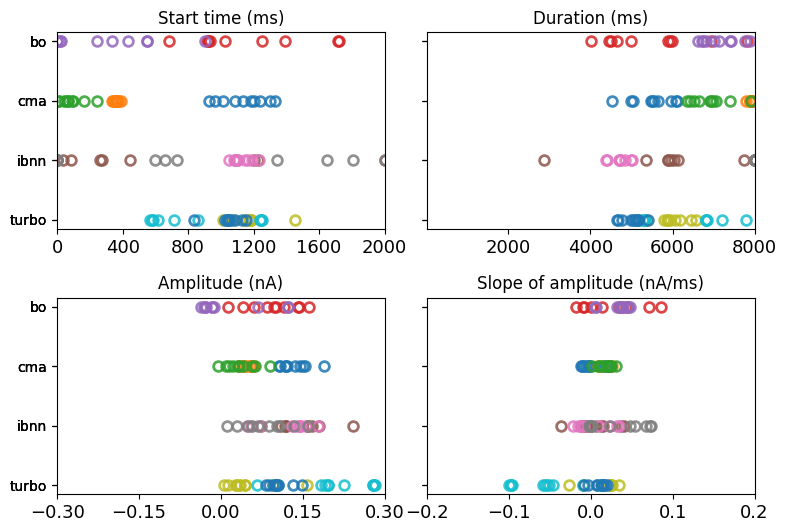

In [77]:
num_top_points = 10

all_results_dir_dict = shared_utils.get_all_results_dir_dict()
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict, verbose=False)

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
for i in range(4):
    ax = axes.flatten()[i]
    ax = plot_eval_utils.plot_top_param_distributions(space, stim_bounds, x_dict, y_dict, ax=ax, num_top_points=num_top_points, show_plot=False, 
                                                      indices_to_plot=[i], method_to_y_pos_mapping=method_to_y_pos_mapping, param_name_list=param_name_list,
                                                      y_tick_label_mapping=y_tick_label_mapping)
    if i in [1, 3]:
        ax.set_yticklabels([])

# plt.tight_layout()
fig.subplots_adjust(wspace=0.13, hspace=0.35)

## by params

In [78]:
space = set_param_space.space
stim_bounds = set_param_space.stim_bounds

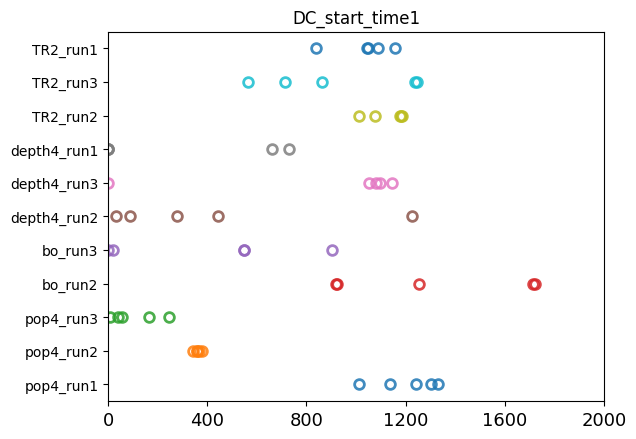

In [79]:
results_dir_dict = {}
for subfolder in ['all_cma', 'all_bo', 'all_ibnn', 'all_turboM']:
    method_dir = os.path.join('all_stored_results', subfolder)
    folders = [f for f in os.listdir(method_dir) if os.path.isdir(os.path.join(method_dir, f))]
    for folder in folders:
        results_dir_dict[folder] = os.path.join(method_dir, folder)
x_dict, y_dict = shared_utils.load_top_optimization_results(results_dir_dict, verbose=False)

# indices_to_plot = [2, 3, 6, 7]
indices_to_plot = range(4)
plot_eval_utils.plot_top_param_distributions(space, stim_bounds, x_dict, y_dict, indices_to_plot=indices_to_plot)

# Appendix

## rerun simulation

WARNING    't' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([ 0.1,  0.2,  0.3, ..., 42.7, 42.8, 42.9]) * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([ 0.1,  0.2,  0.3, ..., 42.7, 42.8, 42.9]) * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 8.1 s
1.9316 s (23%) simulated in 10s, estimated 32s remaining.
3.7602 s (46%) simulated in 20s, estimated 23s remaining.
5.4849 s (67%) simulated in 30s, estimated 14s remaining.
7.3247 s (90%) simulated in 40s, estimated 4s remaining.
8.1 s (100%) simulated in 44s


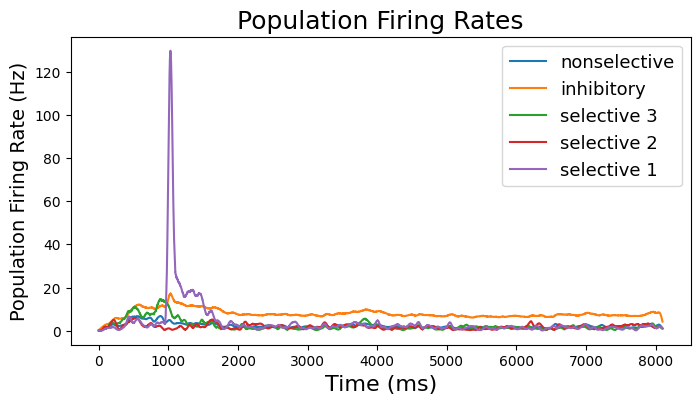

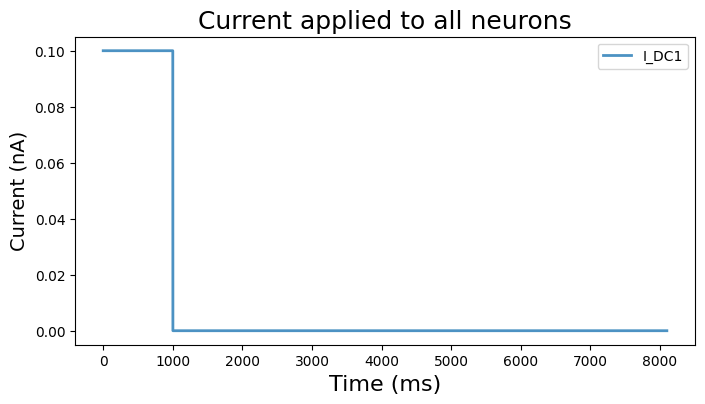

<Figure size 640x480 with 0 Axes>

In [ ]:
# #title_prefix = f'sino_amp2 = {sino_amp2} nA: '
# title_prefix = ''
# net.restore('initial')

# DC_input_ts = 1 * ms
# sino_input_ts = 0.1 * ms

# DC_start_time1 = 0  # in ms
# DC_duration1 = 1000  # in ms
# DC_amp1 = 0.1  # in nA
# DC_amp_slope1 = 0.001  # in nA/ms

# DC_start_time2 = 500  # in ms
# DC_duration2 = 2000  # in ms
# DC_amp2 = -0.05  # in nA
# DC_amp_slope2 = 0.001  # in nA/ms

# # sino_start_time1 = 0  # in ms
# # sino_duration1=3000  # in ms
# # sino_amp1=0.08  # in nA
# # sino_freq1=5  # in Hz

# # sino_start_time2 = 1000  # in ms
# # sino_duration2=2000  # in ms
# # sino_amp2=0.06  # in nA
# # sino_freq2=10  # in Hz


# DC_input1 = set_params_utils.set_DC_input(DC_amp=DC_amp1, # in nA
#             DC_duration=DC_duration1, # in ms
#             DC_start_time=DC_start_time1, # in ms
#             timestep=DC_input_ts
#             )

# # DC_input2 = set_params_utils.set_DC_input(DC_amp=DC_amp2, # in nA
# #             DC_duration=DC_duration2, # in ms
# #             DC_start_time=DC_start_time2, # in ms
# #             timestep=DC_input_ts
# #             )

# # sino_input1 = set_params_utils.set_sino_input(sino_start_time=sino_start_time1, # in ms
# #                 sino_duration=sino_duration1, # in ms
# #                 sino_amp=sino_amp1, # in nA
# #                 sino_freq=sino_freq1, # in Hz
# #                 timestep=sino_input_ts
# #                 )

# # sino_input2 = set_params_utils.set_sino_input(sino_start_time=sino_start_time2, # in ms
# #                 sino_duration=sino_duration2, # in ms
# #                 sino_amp=sino_amp2, # in nA
# #                 sino_freq=sino_freq2, # in Hz
# #                 timestep=sino_input_ts
# #                 )


# net.run(8.1 * second, report='stdout')
# plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels, title_prefix=title_prefix)
# # plotting_utils.plot_currents(current_monitor_E, current_monitor_I, currents_to_plot, E_index_map, title_prefix=title_prefix)

# plotting_utils.plot_currents(current_monitor_E, None, ['I_DC1'], E_index_map, title_prefix='')
# plt.gcf().subplots_adjust(left=0.25)


## test obj func

In [ ]:
objective_with_factor = partial(obj_func_utils.objective_function, net=net, namespace=namespace, stim_bounds=stim_bounds, current_monitor_E=current_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                E_index_map=E_index_map, maximize=False, plotting=True)


In [ ]:
DC_start_time1 = 1000  # in ms
DC_duration1 = 300  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

# DC_start_time2 = 200  # in ms
# DC_duration2 = 1000  # in ms
# DC_amp2 = -0.05  # in nA
# DC_amp_slope2 = -0.001  # in nA/ms

# sino_start_time1 = 0  # in ms
# sino_duration1=1000  # in ms
# sino_amp1=0.5  # in nA
# sino_freq1=20  # in Hz

# sino_start_time2 = 1000  # in ms
# sino_duration2=500  # in ms
# sino_amp2=0.2  # in nA
# sino_freq2=10  # in Hz


# make sure that we can run the below with no bugs
params = [DC_start_time1, DC_duration1, DC_amp1, DC_amp_slope1,
        #  DC_start_time2, DC_duration2, DC_amp2, DC_amp_slope2, 
        #   sino_start_time1, sino_duration1, sino_amp1, sino_freq1,
        #   sino_start_time2, sino_duration2, sino_amp2, sino_freq2
          ]

stim_bounds_array = np.array(stim_bounds)
params_norm = (np.array(params) - stim_bounds_array[0,:]) / (stim_bounds_array[1,:] - stim_bounds_array[0,:])

objective_with_factor(params_norm)

## test smoothing width of firing rate

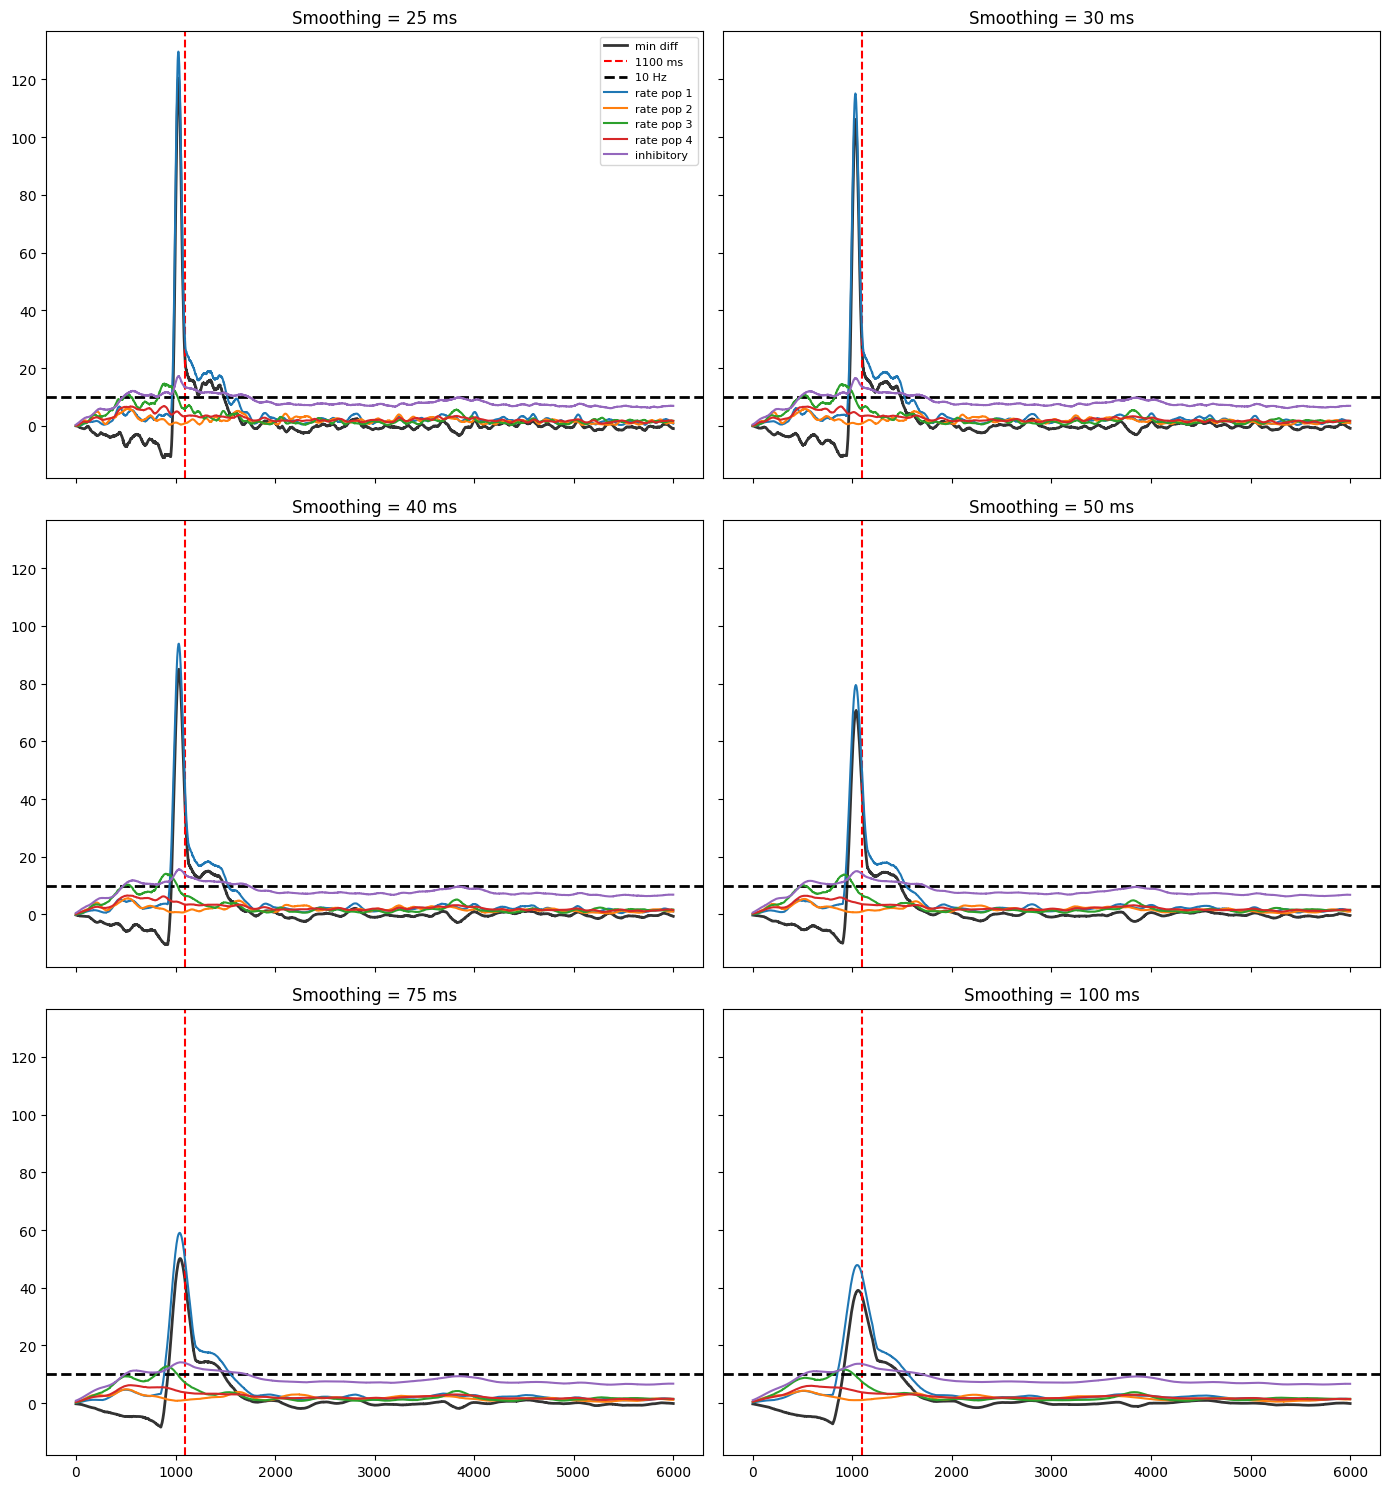

In [113]:
# Settings
fr_window = [0, 6000]
smoothing_widths = [25, 30, 40, 50, 75, 100]  # in ms
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 7, num_rows * 5), sharex=True, sharey=True)
axes = axes.flatten()

for idx, width in enumerate(smoothing_widths):
    if idx >= len(axes):
        break  # prevent index error if grid is too small

    ax = axes[idx]
    smoothing_width = width * ms

    # Compute firing rates
    t_in_window, rates_sel = [], []
    for i in range(3):
        t, rate, _ = obj_func_utils.calculate_fr_in_window(
            r_E_sels[i], fr_window=fr_window, smoothing_width=smoothing_width)
        t_in_window = t  # assume same for all
        rates_sel.append(rate)

    _, rate_non_sel, _ = obj_func_utils.calculate_fr_in_window(
        r_E, fr_window=fr_window, smoothing_width=smoothing_width)

    # Differences
    diff_12 = rates_sel[0] - rates_sel[1]
    diff_13 = rates_sel[0] - rates_sel[2]
    diff_14 = rates_sel[0] - rate_non_sel
    min_diff = np.minimum.reduce([diff_12, diff_13, diff_14])

    # Plot
    ax.plot(t_in_window / ms, min_diff, label='min diff', linewidth=2, color='black', alpha=0.8)
    ax.axvline(x=1100, color='r', linestyle='--', label='1100 ms')
    ax.axhline(y=10, color='black', linestyle='--', linewidth=2, label='10 Hz')
    ax.plot(t_in_window / ms, rates_sel[0], label='rate pop 1')
    ax.plot(t_in_window / ms, rates_sel[1], label='rate pop 2')
    ax.plot(t_in_window / ms, rates_sel[2], label='rate pop 3')
    ax.plot(t_in_window / ms, rate_non_sel, label='rate pop 4')

    _, rate_I, _ = obj_func_utils.calculate_fr_in_window(
        r_I, fr_window=fr_window, smoothing_width=smoothing_width)
    
    ax.plot(t_in_window / ms, rate_I, label='inhibitory')
    ax.set_title(f'Smoothing = {width} ms')

    if idx == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
t_in_window, rate_in_window, mean_fr = obj_func_utils.calculate_fr_in_window(r_E_sels[0])

## plot count over threshold by hyperparameters

Note: the plot here cannot show hyperparameters because only one set of hyperparameters are used for each method during final training. This plot is mostly used during the hyperparameter tuning stage.

Method: bo


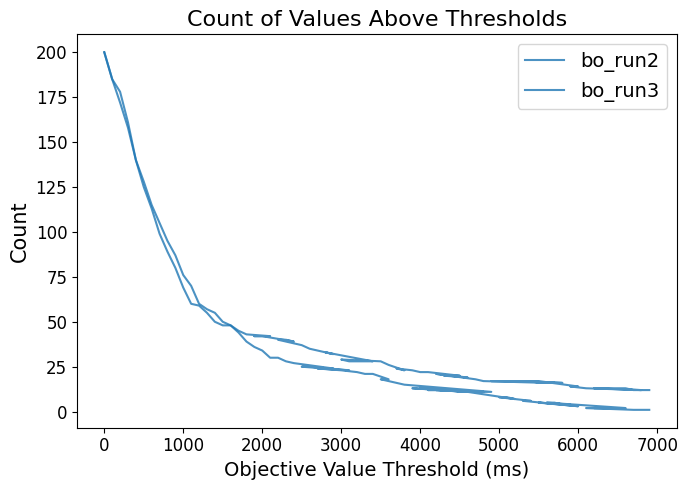

Method: cma


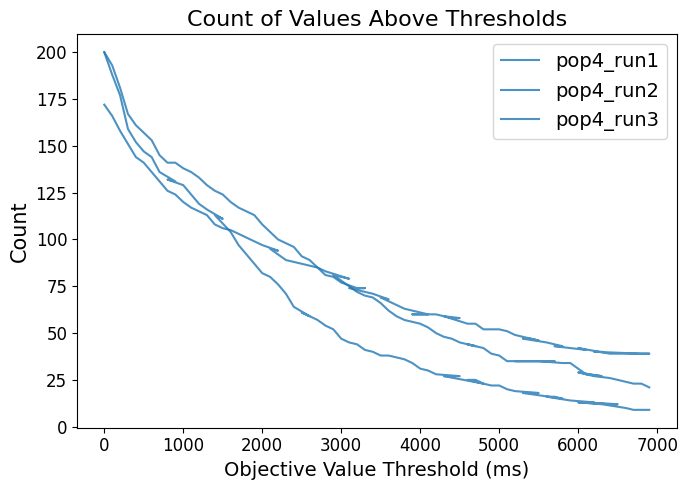

Method: ibnn


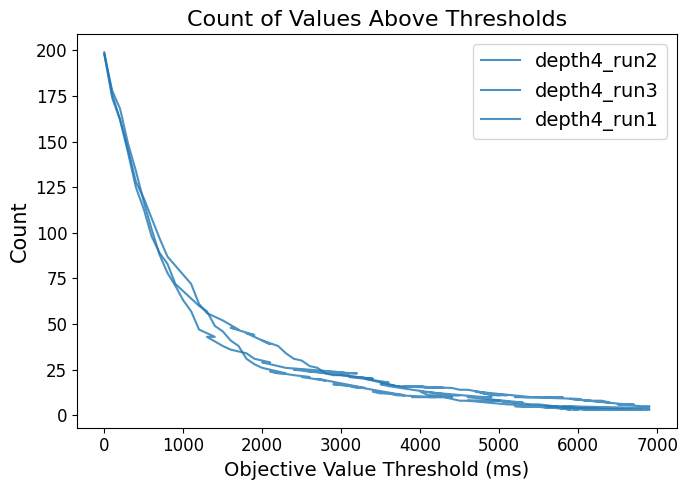

Method: turbo


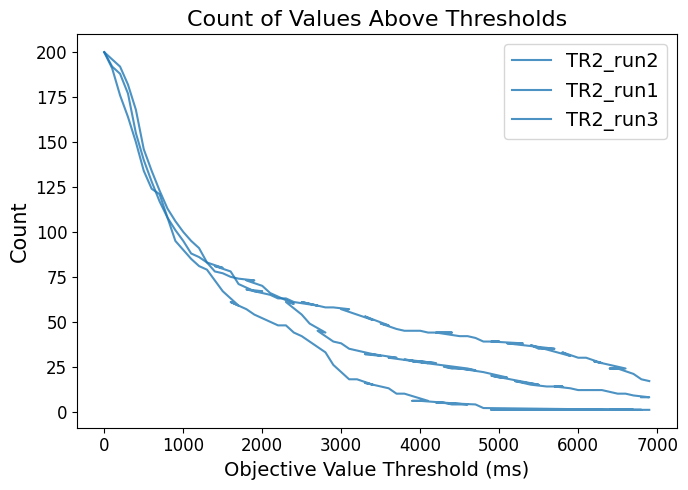

In [96]:
# if combine all instances across methods
all_results_dir_dict = shared_utils.get_all_results_dir_dict()
x_dict, y_dict = shared_utils.load_top_optimization_results(all_results_dir_dict, verbose=False)

comb_df = eval_utils.get_count_of_high_values_over_threshold(y_dict, one_instance_per_method=False)
for method in comb_df.method.unique():
    print(f"Method: {method}")
    sub_df = comb_df[comb_df.method == method].sort_values(by='percentage', ascending=False)

    unique_labels = sub_df['hyperparam'].sort_values().unique()
    
    if method != 'turboM':
        colors = color_map_package.get_cmap('tab10')
        
    else:
        # get a continuous color map
        colors = color_map_package.get_cmap('PiYG', len(unique_labels))

    color_map  = {label: colors(i) for i, label in enumerate(unique_labels)}
    plot_eval_utils.plot_count_over_value_thresholds(sub_df, groupby_column='name', color_map=color_map, color_column='hyperparam')

## check positions of top params

In [117]:
all_results_dir_dict = shared_utils.get_all_results_dir_dict()

verbose = True
prefix = 'run_'
num_repeats = 10
num_top_points = 10

all_methods = all_results_dir_dict.keys()

for method in all_methods:
    result_dir = all_results_dir_dict[method]
    if verbose:
        print(f"Method: {method}")
    updated_x, updated_y = shared_utils.get_latest_results(result_dir)

    top_indices = torch.topk(updated_y.squeeze(), num_top_points).indices
    print(top_indices)

Method: pop4_run1
tensor([184, 183, 174, 138, 118, 178, 194, 176, 177, 117])
Method: pop4_run2
tensor([171, 170, 169, 168, 118, 167, 166, 165, 124, 108])
Method: pop4_run3
tensor([138, 102, 168, 179, 183, 131, 177, 175, 188, 189])
Method: bo_run1
tensor([ 41, 164,  47,  40,  42,  35,  32,  37,  62,  39])
Method: bo_run2
tensor([ 42, 175,  16, 130,  45, 176, 174,  12, 169, 183])
Method: bo_run3
tensor([83, 24, 25,  3, 60, 35, 37, 26, 33, 38])
Method: depth4_run2
tensor([187,  30,   6,  57, 178,  73,  65, 182, 104, 184])
Method: depth4_run3
tensor([186, 181,  84, 190, 187, 182,  80,   7,  57, 183])
Method: depth4_run1
tensor([ 93,  95, 116,  89, 117, 118, 195, 151, 163, 150])
Method: TR2_run2
tensor([55, 60, 63, 66, 45, 68, 43, 72, 74, 78])
Method: TR2_run3
tensor([192, 195, 107, 167, 176, 106, 114,  99, 161, 143])
Method: TR2_run1
tensor([145, 157, 155, 153, 161, 166, 174, 146, 158, 142])


## truncate iterations
In this case, we want to evaluate the first 200 iterations, and yet some methods have more than 200 iterations. We will truncate the extra iterations


In [118]:

all_results_dir_dict = shared_utils.get_all_results_dir_dict()
all_methods = all_results_dir_dict.keys()


for method in all_methods:
    result_dir = all_results_dir_dict[method]
    try:
        updated_x = torch.load(os.path.join(result_dir, "updated_x.pt"))
        updated_y = torch.load(os.path.join(result_dir, "updated_y.pt"))
    except Exception as e:
        result_dir = shared_utils.get_latest_result_subfolder_name(
            result_dir=result_dir, prefix=prefix)
        updated_x = torch.load(os.path.join(result_dir, "updated_x.pt"))
        updated_y = torch.load(os.path.join(result_dir, "updated_y.pt"))
    
    print(f"Method: {method}, {result_dir}")
    print(updated_x.shape)
    print(updated_y.shape)
    
    # updated_x = updated_x[:200,:]
    # updated_y = updated_y[:200]
    # torch.save(updated_x, os.path.join(result_dir, "updated_x.pt"))
    # torch.save(updated_y, os.path.join(result_dir, "updated_y.pt"))



Method: pop4_run1, all_stored_results/all_cma/pop4_run1
torch.Size([200, 4])
torch.Size([200])
Method: pop4_run2, all_stored_results/all_cma/pop4_run2
torch.Size([172, 4])
torch.Size([172])
Method: pop4_run3, all_stored_results/all_cma/pop4_run3
torch.Size([200, 4])
torch.Size([200])
Method: bo_run1, all_stored_results/all_bo/bo_run1/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: bo_run2, all_stored_results/all_bo/bo_run2/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: bo_run3, all_stored_results/all_bo/bo_run3/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: depth4_run2, all_stored_results/all_ibnn/depth4_run2/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: depth4_run3, all_stored_results/all_ibnn/depth4_run3/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: depth4_run1, all_stored_results/all_ibnn/depth4_run1/run_1
torch.Size([200, 4])
torch.Size([200, 1])
Method: TR2_run2, all_stored_results/all_turboM/TR2_run2
torch.Size([200, 4])
torch.Size([2

## merge avg_eval_df
Currently not used because the individual avg_eval_df for each method has been deleted. Instead, avg_eval_comb has been saved and is retrievable.

In [ ]:
# avg_eval_dir = '/Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation/all_stored_results/compare_methods'

# files = os.listdir(avg_eval_dir)
# avg_files = [f for f in files if 'avg_eval' in f]
# print(avg_files)


# avg_eval_ibnn = pd.read_csv(os.path.join(avg_eval_dir, 'avg_eval_ibnn.csv'))
# avg_eval_cma = pd.read_csv(os.path.join(avg_eval_dir, 'avg_eval_cma.csv'))
# avg_eval_turbo = pd.read_csv(os.path.join(avg_eval_dir, 'avg_eval_turbo.csv'))
# avg_eval_bo = pd.read_csv(os.path.join(avg_eval_dir, 'avg_eval_bo.csv'))

# # merge avg_eval_df
# avg_eval_comb = avg_eval_ibnn.merge(avg_eval_cma, on='Top-K')
# avg_eval_comb = avg_eval_comb.merge(avg_eval_turbo, on='Top-K')
# avg_eval_comb = avg_eval_comb.merge(avg_eval_bo, on='Top-K')

# #avg_eval_comb.to_csv(os.path.join(avg_eval_dir, 'avg_eval_comb.csv'), index=False)

## get method-to-label mapping

In [106]:
# in case we need to plot all runs of each method, and yet only needs the method to appear once in the legend.

method_to_label_mapping = {key: None for key in all_results_dir_dict.keys()}
for key in all_results_dir_dict.keys():
    method, _ = eval_utils.get_method(key)
    # each method only needs to be labeled once
    method_to_y_pos_mapping[key] = method_mapping[method]
    if not method in method_to_label_mapping.values():
        method_to_label_mapping[key] = method
method_to_label_mapping

{'pop4_run1': 'cma',
 'pop4_run2': None,
 'pop4_run3': None,
 'bo_run1': 'bo',
 'bo_run2': None,
 'bo_run3': None,
 'depth4_run2': 'ibnn',
 'depth4_run3': None,
 'depth4_run1': None,
 'TR2_run2': 'turbo',
 'TR2_run3': None,
 'TR2_run1': None}

## plot top-K param repeated eval error bar

In [107]:
iter_df_dir = '/Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation/all_stored_results/compare_methods'
iter_df_comb = pd.read_csv(os.path.join(iter_df_dir, 'iter_df_comb.csv'))
# to ensure that the method names are consistent
iter_df_comb[iter_df_comb['method'] == 'baseline_bo']['method'] = 'bo'

df_summary = (
    iter_df_comb
    .groupby(['method', 'top_k'])
    .agg({'y_value': ['mean', 'std']})
    .reset_index()
)
# Flatten MultiIndex columns
df_summary.columns = ['method', 'top_k', 'mean_y_value', 'std_y_value']

In [ ]:
top_n_to_plot = 10
fig, ax = plt.subplots(figsize=(10, 6))

# Sort so best-performing configs come first per method
df_summary.sort_values(by=['method', 'mean_y_value'], ascending=[True, False], inplace=True)
all_methods = df_summary['method'].unique()

for method in all_methods:
    sub_df = df_summary[df_summary['method'] == method].head(top_n_to_plot)
    
    x_vals = range(1, len(sub_df) + 1)  # 1-based index for top-k
    mean_vals = sub_df['mean_y_value'].values * (fr_window[1] - fr_window[0])
    std_vals = sub_df['std_y_value'].values * (fr_window[1] - fr_window[0])
    
    ax.plot(
        x_vals,
        mean_vals,
        label=method,
        linewidth=2,
        marker='o',
        markersize=5,
        alpha=0.85
    )
    
    ax.fill_between(
        x_vals,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.2
    )

# Labeling and aesthetics
ax.set_xlabel('Top-k Ranked Parameters', fontsize=12)
ax.set_ylabel('Objective Value', fontsize=12)
ax.set_title('Top-k Performance per Method', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()